# Process-oriented workflows

* Difficulty level: easy
* Time need to lean: 20 minutes or less
* Key points:
  * Process-oriented workflow specifies workflows and steps to execute

## Process-oriented workflows

 <div class="bs-callout bs-callout-primary" role="alert">
    <p><b>Process-oriented workflows</b> execute user-specified workflows or steps. For example, sos run script A would execute a workflow named A, which can be a single-step workflow with step A, or a multi-step workflow with steps such as A_10, A_20. The workflow may or may not generate any output.</p>
        </div>
        

**Process-oriented** workflows execute steps. For example, the first example in our [tutorial on SoS workflow](sos_overview.html) defines a workflow `plot` with two steps `plot_10` and `plot_20`. The magic `%run` plot or command `sos run script plot` executes all steps in the workflow, regardless of these steps produce any output.

In [1]:
%run plot -v1

[global]
excel_file = 'data/DEG.xlsx'
csv_file = 'DEG.csv'
figure_file = 'output.pdf'

[plot_10]
run: expand=True
    xlsx2csv {excel_file} > {csv_file}

[plot_20]
R: expand=True
    data <- read.csv('{csv_file}')
    pdf('{figure_file}')
    plot(data$log2FoldChange, data$stat)
    dev.off()

xlsx2csv data/DEG.xlsx > DEG.csv

null device 
          1 


## Default input of numerically-indexed steps

The previous example simply lists all the scripts for each step and does not specify the input and output of the step. **SoS assumes that steps without `input` statement depends on all its previous steps**. That is to say, `plot_20` will be executed after `plot_10`, and `plot_30`, if exists, will be executed after both steps `plot_10` and `plot_20`. The entire step will be executed sequentially.

You can add `input` and `output` statements to the steps, which allows you to

* Use variables `_input` and `_output` in scripts, which is arguably more readable.
* Allows SoS to track the input and output of steps and create signatures. Steps will be ignored if they have been executed before. See [runtime signature](signature.html) for details.
* Allows SoS to determine step dependencies and create DAGs so that SoS can execute steps in parallel (see next section).

The following workflow is the version of the previous workflow with `input` and `output` statements. Note that, however, that `plot_20` does not define input because **a numerically-indexed step by default takes the `step_output` of its previous step (`step_10` in this case) as its `step_input`**.

In [2]:
%run plot -s force -v1

[global]
excel_file = 'data/DEG.xlsx'
csv_file = 'DEG.csv'
figure_file = 'output.pdf'

[plot_10]
input: excel_file
output: csv_file
run: expand=True
    xlsx2csv {_input} > {_output}

[plot_20]
output: figure_file
R: expand=True
    data <- read.csv('{_input}')
    pdf('{_output}')
    plot(data$log2FoldChange, data$stat)
    dev.off()

xlsx2csv data/DEG.xlsx > DEG.csv

null device 
          1 


## DAG of process-oriented workflow

Concepturally speaking process-oriented workflows are executed sequentially. When you design a workflow, you focus on initial input files, and how they are processed step by step. However, in a complex workflow, there will be branches of the process and you can execute these branches in parallel if you specify input and output of steps.

For example, your workflow can have multiple starting points with different input files:

Summarizing results


> dag1.dot (664 B):

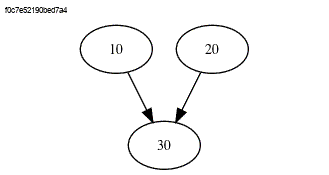

In [3]:
!touch a.txt b.txt
%preview dag1.dot

%run -v1 -d dag1.dot

import time

[10]
input: 'a.txt'
output: 'a.bak'
print(f'Generating {_output} at step {step_name}')
_output.touch()
time.sleep(5)

[20]
input: 'b.txt'
output: 'b.res'
print(f'Generating {_output} at step {step_name}')

_output.touch()
time.sleep(3)

[30]
input: 'a.bak', 'b.res'
print('Summarizing results')

In this workflow, steps `10` and `20` are executed in parallel because they have different input files and do not depend on each other.

As a slightly more complex example, the following workflow has two longer branches with `20` executed after `10`, and `40` after `30`. More interestingly, because it takes longer for step `10` to execute, step `40` actually starts before step `20`. That is to say, **although the workflow executes sequentially conceptually, in really the steps could be executed out of their numerical order**.

Generating a.bak at step 10
Generating b.res at step 30
Generating b.res1 at step 40
Generating a.bak1 at step 20
Summarizing results


> dag2.dot (1.5 KiB):

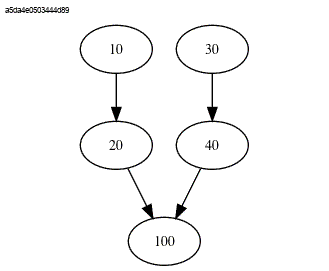

In [4]:
!touch a.txt b.txt
%preview dag2.dot

%run -v1 -s force -d dag2.dot

import time

[10]
input: 'a.txt'
output: 'a.bak'
print(f'Generating {_output} at step {step_name}')
_output.touch()
time.sleep(5)

[20]
time.sleep(5)
output: 'a.bak1'

print(f'Generating {_output} at step {step_name}')
_output.touch()

[30]
input: 'b.txt'
output: 'b.res'
print(f'Generating {_output} at step {step_name}')

_output.touch()
time.sleep(1)

[40]
output: 'b.res1'

print(f'Generating {_output} at step {step_name}')
_output.touch()
time.sleep(5)

[100]
input: 'a.bak1', 'b.res1'
print('Summarizing results')

## Further reading
* [Named inputs](named_input.html)
* [Named outputs](named_output.html)